# Supervised Machine Learning: Regression and Classification

In [1]:
import matplotlib.pyplot as plt
from lab_utils_uni import plt_intuition, plt_stationary, plt_update_onclick, soup_bowl

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, unix_timestamp, col, regexp_replace
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation

import numpy as np
import math

## Pyspark config

In [ ]:
# SPAWN A SPARKSESSION
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.cores", "12").\
        config("spark.executor.memory", "1024mb").\
        getOrCreate()

In [3]:
# Read dataset for this course and cache() it
data = spark.read.csv(path="hdfs://namenode:9000/data/when2heat.csv", sep=";", header=True)

data.cache()

DataFrame[utc_timestamp: string, cet_cest_timestamp: string, AT_COP_ASHP_floor: string, AT_COP_ASHP_radiator: string, AT_COP_ASHP_water: string, AT_COP_GSHP_floor: string, AT_COP_GSHP_radiator: string, AT_COP_GSHP_water: string, AT_COP_WSHP_floor: string, AT_COP_WSHP_radiator: string, AT_COP_WSHP_water: string, AT_heat_demand_space: string, AT_heat_demand_space_COM: string, AT_heat_demand_space_MFH: string, AT_heat_demand_space_SFH: string, AT_heat_demand_total: string, AT_heat_demand_water: string, AT_heat_demand_water_COM: string, AT_heat_demand_water_MFH: string, AT_heat_demand_water_SFH: string, AT_heat_profile_space_COM: string, AT_heat_profile_space_MFH: string, AT_heat_profile_space_SFH: string, AT_heat_profile_water_COM: string, AT_heat_profile_water_MFH: string, AT_heat_profile_water_SFH: string, BE_COP_ASHP_floor: string, BE_COP_ASHP_radiator: string, BE_COP_ASHP_water: string, BE_COP_GSHP_floor: string, BE_COP_GSHP_radiator: string, BE_COP_GSHP_water: string, BE_COP_WSHP_flo

In [4]:
# PERFORM TRANSFORMATIONS TO DATAFRAME BY REPLACING COMMAS WITH DOTS AND CAST TO INT 

data = data.select([regexp_replace(col, r'[,]', '.').alias(col) for col in data.columns])\
        .withColumn("utc_timestamp", unix_timestamp("utc_timestamp", format="yyyy-MM-dd'T'kk:mm:ss'Z'").cast('int'))\
        .withColumn("AT_heat_demand_space", col("AT_heat_demand_space").cast('int'))

In [5]:
data.show()

+-------------+--------------------+-----------------+--------------------+-----------------+-----------------+--------------------+-----------------+-----------------+--------------------+-----------------+--------------------+------------------------+------------------------+------------------------+--------------------+--------------------+------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+-----------------+--------------------+-----------------+-----------------+--------------------+-----------------+-----------------+--------------------+-----------------+--------------------+------------------------+------------------------+------------------------+--------------------+--------------------+------------------------+------------------------+------------------------+-------------------------+--------------

In [6]:
from pyspark.sql.functions import unix_timestamp, col
data.printSchema()

root
 |-- utc_timestamp: integer (nullable = true)
 |-- cet_cest_timestamp: string (nullable = true)
 |-- AT_COP_ASHP_floor: string (nullable = true)
 |-- AT_COP_ASHP_radiator: string (nullable = true)
 |-- AT_COP_ASHP_water: string (nullable = true)
 |-- AT_COP_GSHP_floor: string (nullable = true)
 |-- AT_COP_GSHP_radiator: string (nullable = true)
 |-- AT_COP_GSHP_water: string (nullable = true)
 |-- AT_COP_WSHP_floor: string (nullable = true)
 |-- AT_COP_WSHP_radiator: string (nullable = true)
 |-- AT_COP_WSHP_water: string (nullable = true)
 |-- AT_heat_demand_space: integer (nullable = true)
 |-- AT_heat_demand_space_COM: string (nullable = true)
 |-- AT_heat_demand_space_MFH: string (nullable = true)
 |-- AT_heat_demand_space_SFH: string (nullable = true)
 |-- AT_heat_demand_total: string (nullable = true)
 |-- AT_heat_demand_water: string (nullable = true)
 |-- AT_heat_demand_water_COM: string (nullable = true)
 |-- AT_heat_demand_water_MFH: string (nullable = true)
 |-- AT_heat

## Week 1

### Applications of Machine Learning

- Machine Learning learns from experience (Data)
- There are four types of machine learning categories:
    - Supervised learning
    - Unsupervised learning
    - Recommender system
    - Reinforcement learning



#### Supervised learning

##### Linear regression

![alt text](1.png)

The equation for univariate linear regression is
$$
\hat{y} = mx + b
$$

where:
- \( $ \hat{y} $ \) is the prediction
- \( x \) is the (single) feature
- Parameters
    - \( m \) is the slope of the line
    - \( b \) is the y-intercept of the line

In [65]:
def compute_linear_function(x, w, b):
    """
    Computes the prediction of a linear model
    Args:
      x (ndarray (m,)): Data, m examples 
      w,b (scalar)    : model parameters  
    Returns
      y (ndarray (m,)): target values
    """
    m = x.shape[0]
    f_wb = np.zeros(m)
    for i in range(m):
        f_wb[i] = w * x[i] + b
        
    return f_wb

In [63]:
w = -3.7669350720405187e-06
b = 11883.3
print(f"w: {w}")
print(f"b: {b}")

w: -3.7669350720405187e-06
b: 11883.3


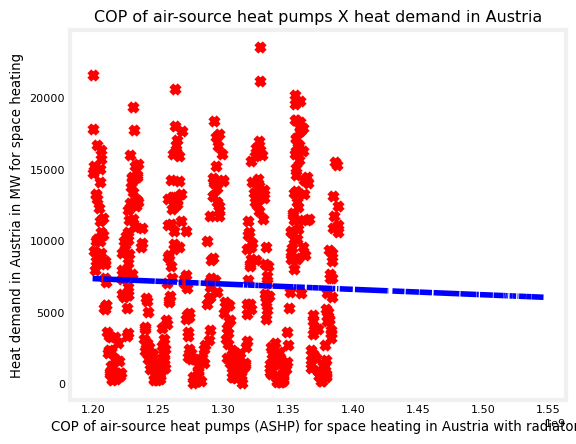

In [66]:
# PLOT A LINEAR FUNCTION ON DATA POINTS

# collect the columns from dataframe
column1 = data.sample(0.01,3).select("utc_timestamp").collect()
column2 = data.sample(0.01,3).select("AT_heat_demand_space").collect()

# Convert the collected columns to numpy arrays
x_train = np.array([row[0] for row in column1]).astype(np.float64)
y_train = np.array([row[0] for row in column2]).astype(np.float64)

tmp_f_wb = compute_linear_function(x_train, w, b,)

plt.plot(x_train, tmp_f_wb, c='b',label='Our Prediction')
plt.scatter(x_train, y_train, marker='x', c='r')
# Set the title
plt.title("COP of air-source heat pumps X heat demand in Austria")
# Set the y-axis label
plt.ylabel('Heat demand in Austria in MW for space heating')
# Set the x-axis label
plt.xlabel('COP of air-source heat pumps (ASHP) for space heating in Austria with radiators')
plt.show()

![alt text](2.png)

$$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 \tag{1}$$

This is the Mean-Squared Error cost function we try to minimize with linear regression. In summary, it measures the distance between predicted values and real values of y. It is one of the most common cost functions. Thus the objective is to:

$$\min J(w,b)$$

In [56]:
# MSE COST FUNCTION FOR LINEAR REGRESSION
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0] 
    
    cost_sum = 0 
    for i in range(m): 
        f_wb = w * x[i] + b   
        cost = (f_wb - y[i]) ** 2
        if not math.isnan(cost):
            cost_sum = cost_sum + cost  
    total_cost = (1 / (2 * m)) * cost_sum  

    return total_cost

In [62]:
compute_cost(x_train,y_train,-3.7669350720405187e-06,11883.3)

8189839.908023564

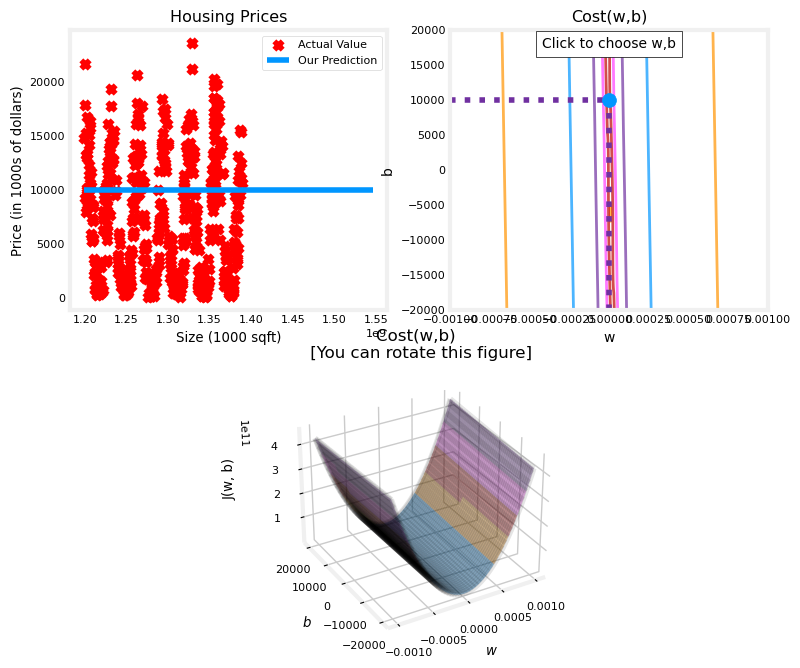

In [31]:
# PLOT COST FUNCTION AS 2D CONTOUR PLOT AND 3D SURFACE PLOT

plt.close('all') 
fig, ax, dyn_items = plt_stationary(x_train, y_train)
updater = plt_update_onclick(fig, ax, x_train, y_train, dyn_items)

Gradient descent, a famous algorithm for minimizing cost functions based on tuning of parameters, can be used to solve linear regression. For example: $$ w = w - \alpha \cdot \frac{\partial J(w, b)}{\partial w} $$ $$ b = b - \alpha \cdot \frac{\partial J(w, b)}{\partial w} $$

where:

- ( w ) and ( b ) are the parameters of the model
- ( $ \alpha $ ) is the learning rate (step size)
- ( $ J(w, b) $ ) is the cost function

In [10]:
# USE VECTORASSEMBLER TO COMBINE THE FEATURES INTO A SINGLE VECTOR COLUMN, THEN CREATE A SPARK DATAFRAME WITH FEATURES+TARGET
# SPLIT SPARK DATAFRAME USING RANDOMSPLIT 80/20

# Create a VectorAssembler to combine the features into a single vector column
# VectorAssembler is a transformer that combines a given list of columns into a single vector column. 
# It is useful for combining raw features and features generated by different feature transformers into a single feature vector, 
# in order to train ML models like logistic regression and decision trees. 
# VectorAssembler accepts the following input column types: all numeric types, boolean type, and vector type. 
# In each row, the values of the input columns will be concatenated into a vector in the specified order.
assembler = VectorAssembler(inputCols=["utc_timestamp"], outputCol="features", handleInvalid="skip")

# Transform the data using the VectorAssembler
transformed_data = assembler.transform(data)

final_data = transformed_data.select("features", "AT_heat_demand_space").na.drop()

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [48]:
# PUT FEATURE AND TARGET IN A VECTOR AND CALCULATE PEARSON CORRELATION

assembler = VectorAssembler(inputCols=["features", "AT_heat_demand_space"], handleInvalid="skip", outputCol='corr_features')
corr_data = assembler.transform(final_data).select('corr_features')
corr_matrix = Correlation.corr(corr_data, 'corr_features', 'pearson')
print(str(corr_matrix.collect()[0][0]))

DenseMatrix([[ 1.        , -0.03359169],
             [-0.03359169,  1.        ]])


In [46]:
# FIND OPTIMAL COEFFICIENTS AND INTERCEPT (m,b) FOR THE LINEAR REGRESSION MODEL
# Create an instance of the LinearRegression estimator
lr = LinearRegression(featuresCol="features", labelCol="AT_heat_demand_space", predictionCol="predicted_AT_heat_demand_space")

# Fit the estimator to the data
model = lr.fit(train_data)

# Get the model's coefficients and intercept
coefficients = model.coefficients
intercept = model.intercept
trainingSummary = model.summary

print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("MSE: %f" % trainingSummary.meanSquaredError)
print("r2: %f" % trainingSummary.r2)

train_data.describe().show()

Coefficients: [-3.766935072039906e-06]
Intercept: 11883.332974417477
RMSE: 5784.082394
MSE: 33455609.146311
r2: 0.001268
+-------+--------------------+
|summary|AT_heat_demand_space|
+-------+--------------------+
|  count|               40564|
|   mean|   7009.909648949808|
| stddev|  5787.8245501776355|
|    min|                  29|
|    max|               27103|
+-------+--------------------+



In [79]:
# EVALUATE LINEAR REGRESSION ON TEST SET
lr_predictions = model.transform(test_data)
lr_predictions.select("predicted_AT_heat_demand_space","AT_heat_demand_space","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="predicted_AT_heat_demand_space", \
                 labelCol="AT_heat_demand_space")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"}))
print("MAE on test data = %g" % lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mse"}))
print("RMSE on test data = %g" % lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "rmse"}))

+------------------------------+--------------------+-------------+
|predicted_AT_heat_demand_space|AT_heat_demand_space|     features|
+------------------------------+--------------------+-------------+
|             7366.215796328882|               12443|[1.1991492E9]|
|             7366.161552463845|               21158|[1.1991636E9]|
|             7366.134430531326|               20832|[1.1991708E9]|
|             7366.066625700028|               17822|[1.1991888E9]|
|            7365.9852599024725|               18764|[1.1992104E9]|
+------------------------------+--------------------+-------------+
only showing top 5 rows

R Squared (R2) on test data = 0.000507052
MAE on test data = 3.34212e+07
RMSE on test data = 5781.11
